In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime

In [2]:
def parse_and_process_file(file_path, subject_name, side):
    """
    Reads a CSV file, parses points, explodes them into individual rows,
    calculates R, and filters out empty entries.
    """
    # Define column names explicitly to handle the comma in the header
    cols = ['Longitude', 'SizeIndex', 'Intensity', 'Points', 'NormedValue']

    try:
        # Read the file, skipping the header row
        df = pd.read_csv(file_path, skiprows=1, names=cols)
    except FileNotFoundError:
        print(f"Warning: File not found {file_path}")
        return None

    # Function to extract (phi, theta) pairs from the string
    def extract_points(s):
        if pd.isna(s) or str(s).strip() == '[]' or str(s).strip() == '':
            return []
        # Regex finds all pairs like (19.56|0) inside the string
        matches = re.findall(r'\((.*?)\|(.*?)\)', str(s))
        try:
            return [(float(m[0]), float(m[1])) for m in matches]
        except ValueError:
            return []

    # 1. Parse the string column into a list of tuples
    df['ParsedPoints'] = df['Points'].apply(extract_points)

    # 2. Explode the list so each point gets its own row
    # This duplicates 'Longitude' and other columns for each point
    df_exploded = df.explode('ParsedPoints')

    # 3. Remove rows where no points were found
    # If the list was empty, 'ParsedPoints' becomes NaN (or similar) after explode
    df_final = df_exploded.dropna(subset=['ParsedPoints'])

    # 4. Extract Phi and Theta from the tuples
    def get_phi(x):
        return x[0]
    def get_theta(x):
        return x[1]

    df_final['Phi'] = df_final['ParsedPoints'].apply(get_phi)
    df_final['Theta'] = df_final['ParsedPoints'].apply(get_theta)

    # 5. Calculate R = sqrt(phi^2 + theta^2)
    df_final['R'] = np.sqrt(df_final['Phi']**2 + df_final['Theta']**2)

    # 6. Add metadata
    df_final['Subject'] = subject_name
    df_final['Side'] = side

    # Clean up intermediate column
    df_final = df_final.drop(columns=['ParsedPoints'])

    return df_final

In [3]:
# --- Main Execution ---

all_data = []
base_path = "../../Measurements"  # Current directory

# Loop through subjects 1 to 9
for i in range(1, 10):
    subject = f"Subject{i}"

    # Define paths (adjust base_path if your folders are somewhere specific)
    path_right = os.path.join(base_path, subject, "Right.csv")
    path_left = os.path.join(base_path, subject, "Left.csv")

    # Process Right
    df_right = parse_and_process_file(path_right, subject, "Right")
    if df_right is not None:
        all_data.append(df_right)

    # Process Left
    df_left = parse_and_process_file(path_left, subject, "Left")
    if df_left is not None:
        all_data.append(df_left)


# Combine everything into one big DataFrame
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    all_detect_points = final_df["R"].count()
    print(f"The number of detected points is {all_detect_points}")
    final_df = final_df[final_df['R'] <= 75]
    filtered_points = final_df["R"].count()
    print(f"The number of filtered points is {filtered_points}")
    # roman_map = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5}
    extracted_numbers = final_df['SizeIndex'].str.extract(r'Size_(I|II|III|IV|V)')[0]#.map(roman_map)
    final_df['Intensity'] = extracted_numbers.astype(str)  + final_df['Intensity']

    # Display the result
    print("Data loaded successfully!")
    print(final_df.head())
    print(final_df.info())
else:
    raise Exception("No data loaded. Check your folder paths.")
    print("No data loaded. Check your folder paths.")

ground_truth = pd.read_csv(os.path.join(base_path, 'normal_values_group_old.csv'))

# 2. Transform from 'Wide' to 'Long' format
# This moves the stimulus names (V4e, I3e, etc.) into a single column
df_ground_truth_right = ground_truth.melt(
    id_vars=['Meridian_Deg'],            # The column to keep as is
    value_vars=['V4e', 'I3e', 'I2e'],   # The columns to 'unpivot'
    var_name='Intensity',                # Name for the new stimulus column
    value_name='R'                 # Name for the new radius column
).rename(columns={'Meridian_Deg': 'Longitude'})
df_ground_truth_left = df_ground_truth_right.copy()
df_ground_truth_left['Longitude'] = (180 - df_ground_truth_left['Longitude']) % 360
df_ground_truth_left = df_ground_truth_left.sort_values(by=['Intensity', 'Longitude'])
df_ground_truth_right = df_ground_truth_right.sort_values(by=['Intensity', 'Longitude'])


The number of detected points is 1294
The number of filtered points is 1252
Data loaded successfully!
   Longitude SizeIndex Intensity                      Points  NormedValue  \
0          0    Size_I       I2e  [(19.5647|0);(21.2474|0);]      13.6554   
1          0    Size_I       I2e  [(19.5647|0);(21.2474|0);]      13.6554   
2          0    Size_I       I3e  [(36.3575|0);(35.4856|0);]      13.6554   
3          0    Size_I       I3e  [(36.3575|0);(35.4856|0);]      13.6554   
4          0    Size_V       V4e  [(45.5563|0);(46.3168|0);]      13.6554   

       Phi  Theta        R   Subject   Side  
0  19.5647    0.0  19.5647  Subject1  Right  
1  21.2474    0.0  21.2474  Subject1  Right  
2  36.3575    0.0  36.3575  Subject1  Right  
3  35.4856    0.0  35.4856  Subject1  Right  
4  45.5563    0.0  45.5563  Subject1  Right  
<class 'pandas.DataFrame'>
Index: 1252 entries, 0 to 1293
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------

In [4]:
def plot_goldmann_perimeter(df, eye, date_exam, name:str):
    """
    Plots a clinical Goldmann perimeter sheet from a DataFrame.

    Parameters:
    - df: pandas DataFrame with columns ['meridian', 'radius', 'stimulus']
    - eye: str, 'R' (OD) or 'L' (OS)
    - date_exam: datetime object or string
    """

    # 1. Calculate the mean for duplicate stimuli on the same meridian
    # This ensures "mean between them should be calculated" as requested
    df_clean = df

    # 2. Setup the Plot
    fig, ax = plt.subplot_mosaic([['main']], figsize=(10, 10),
                                  subplot_kw={'projection': 'polar'})
    ax = ax['main']

    # 3. Clinical Grid Formatting
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(10, 100, 10))
    # Labels for the degree rings
    ax.set_yticklabels([f"{y}°" if y % 20 == 0 else "" for y in range(10, 100, 10)],
                       color="gray", fontsize=8)

    # Meridian labels (0-360)
    ax.set_thetagrids(np.arange(0, 360, 30), fontsize=10)

    # Clinical Standard Orientation: 0° is East (Temporal for Right, Nasal for Left)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1) # Counter-clockwise

    # 4. Plotting the Isopters
    # Define a color palette for different stimulus types
    unique_stimuli = df_clean['Intensity'].unique()
    # Using a professional color map (tab10)
    colors = plt.colormaps['tab10']
    # colors = plt.cm.get_cmap('tab10', len(unique_stimuli))

    for i, stimulus in enumerate(unique_stimuli):
        subset = df_clean[df_clean['Intensity'] == stimulus].sort_values('Longitude')

        # Convert degrees to radians for plotting
        theta = np.deg2rad(subset['Longitude'].values)
        r = subset['R'].values

        # To draw a closed loop, we "close" the circuit by adding the first point to the end
        theta_closed = np.append(theta, theta[0])
        r_closed = np.append(r, r[0])

        current_color = colors(i)

        # Plot the Isopter line
        ax.plot(theta_closed, r_closed, label=stimulus, color=current_color, linewidth=2)

        # Plot the actual points
        ax.scatter(theta, r, color=current_color, s=25, edgecolors='white', zorder=5)

    # 5. Metadata and Titles
    eye_full = "Right Eye (OD)" if eye.upper() == 'R' else "Left Eye (OS)"
    date_label = date_exam.strftime('%Y-%m-%d') if isinstance(date_exam, datetime) else date_exam

    plt.title(f"Clinical Goldmann Perimetry\n{eye_full}\n{name}",
              pad=30, fontsize=15, fontweight='bold')

    ax.legend(title="Stimulus Isopters", loc='upper right', bbox_to_anchor=(1.2, 1.1))

    plt.tight_layout()
    plt.show()

def calculate_perimetry_metrics(df_recorded, df_ground_truth):
    """
    Calculates point-by-point differences and overall MSE.

    Assumes columns: 'meridian', 'distance', 'intensity', 'radius'
    """

    # 1. Merge the dataframes on the coordinates and stimulus type
    # This aligns the recorded 'radius' with the ground truth 'radius'
    merged = pd.merge(
        df_recorded,
        df_ground_truth,
        on=['Longitude', 'Intensity'],
        suffixes=('_rec', '_gt')
    )

    # 2. Calculate the difference for each point
    # (Recorded Radius - Ground Truth Radius)
    merged['diff'] = merged['R_rec'] - merged['R_gt']

    # 3. Calculate Mean Squared Error (MSE)
    # MSE = Mean of (differences squared)
    mse = np.sqrt((merged['diff']**2).mean())

    return merged, mse

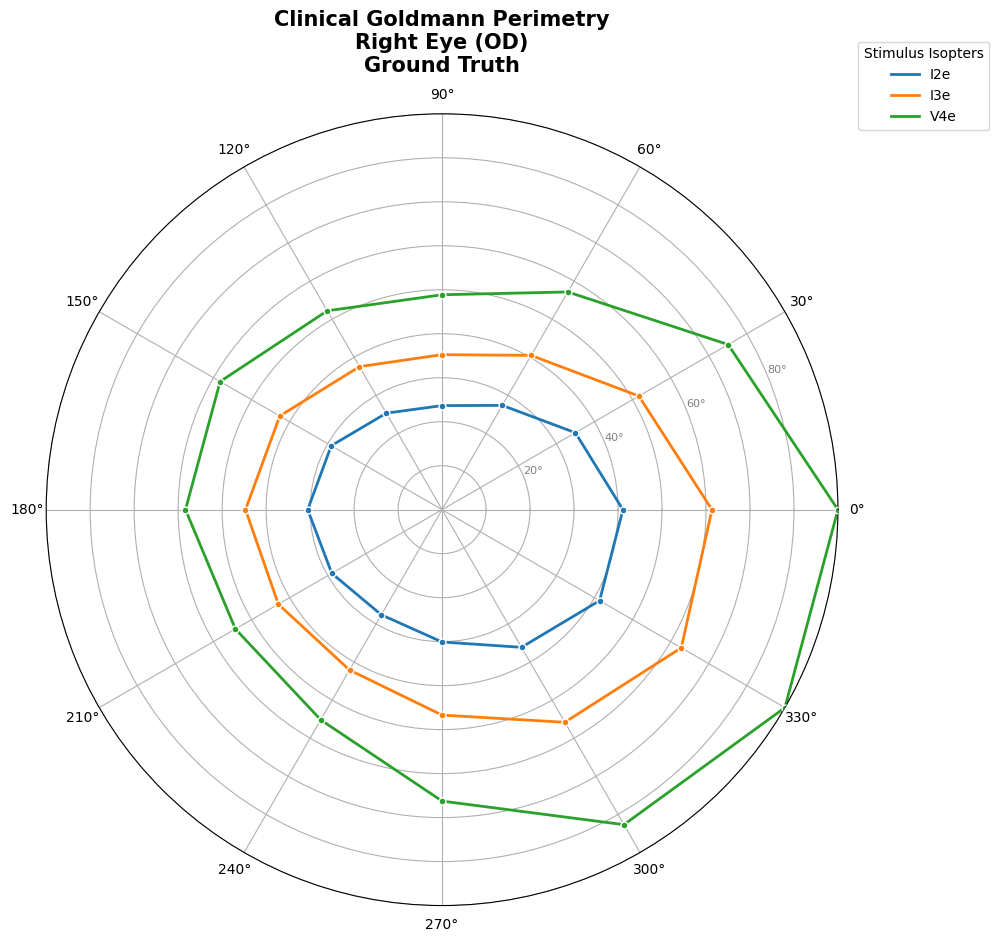

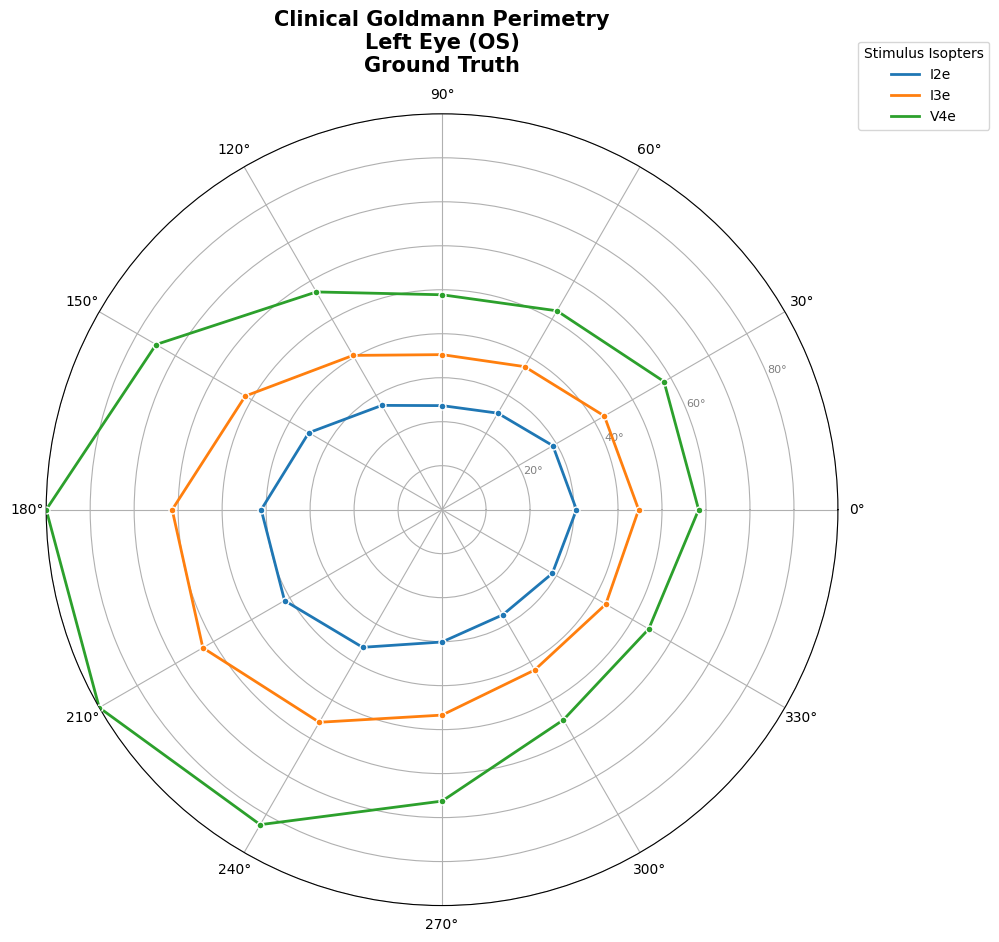

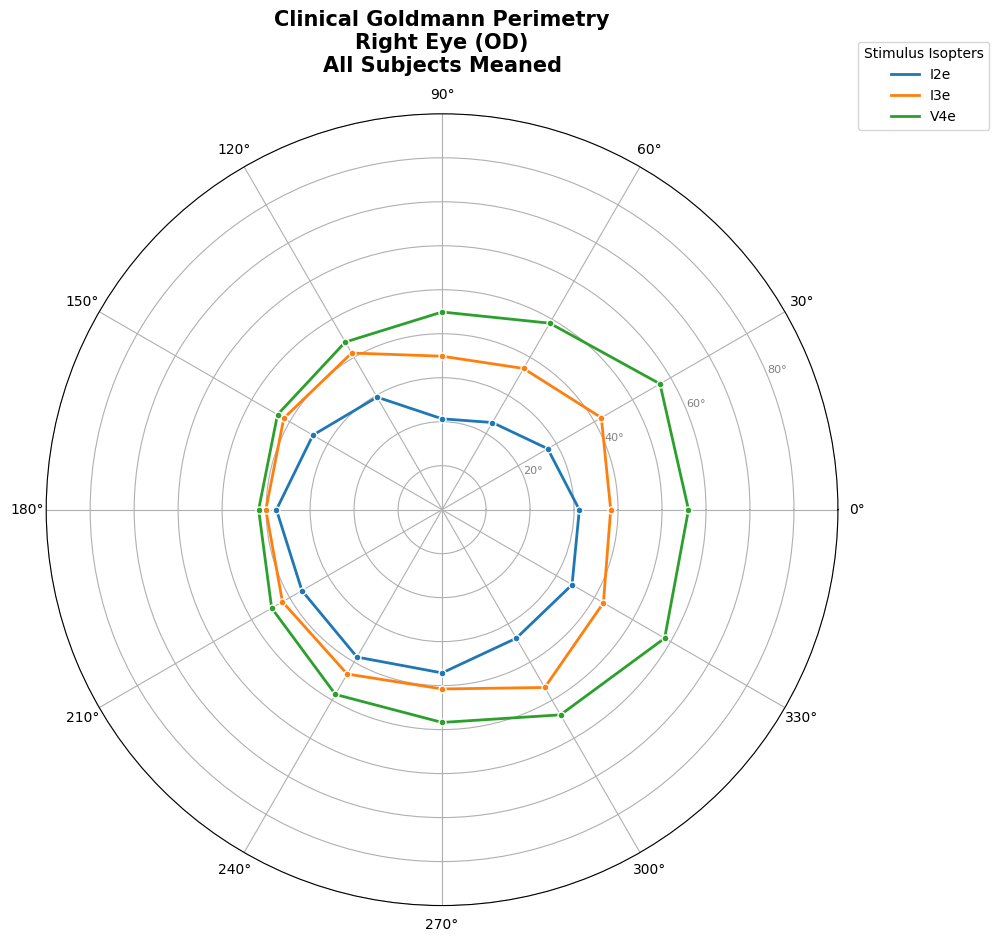

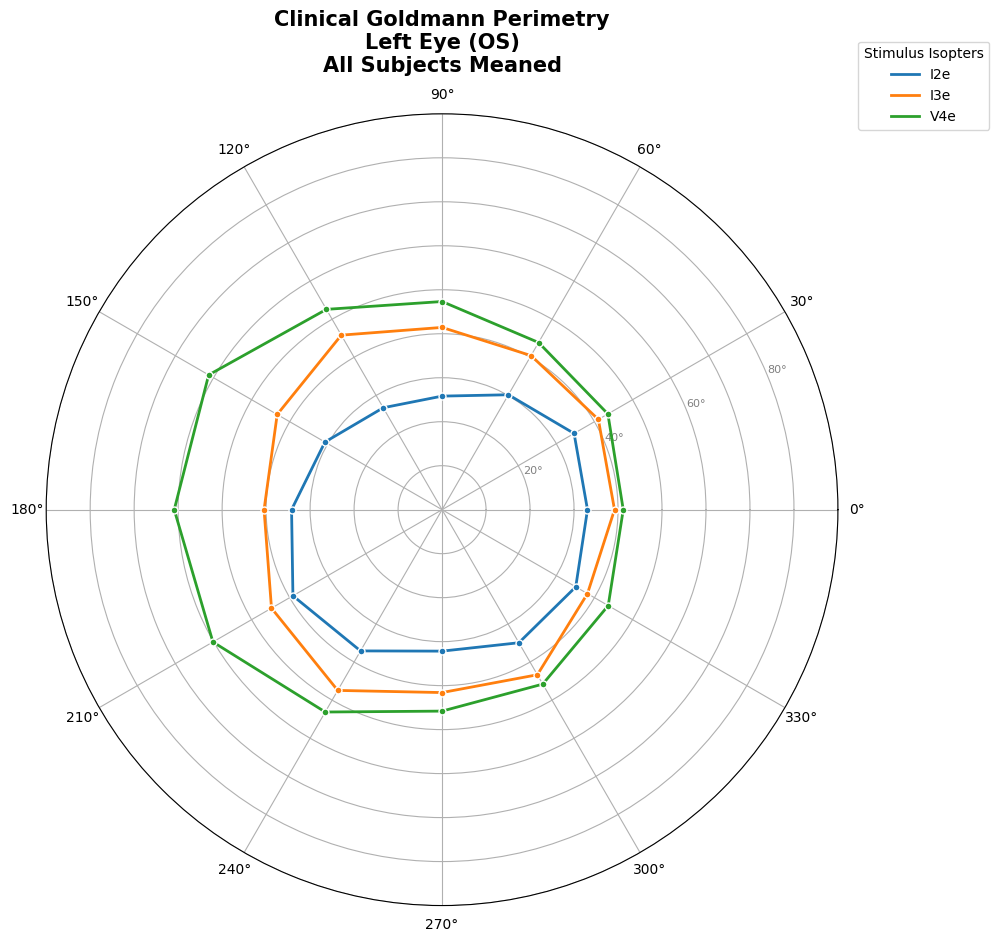

Right General Differences in Deg: 
   Intensity  Longitude   Side      R_rec   R_gt       diff
0        I2e          0  Right  31.208124  41.12  -9.911876
1        I2e         30  Right  27.722981  34.99  -7.267019
2        I2e         60  Right  22.880571  27.38  -4.499429
3        I2e         90  Right  20.658816  23.66  -3.001184
4        I2e        120  Right  29.550416  25.34   4.210416
5        I2e        150  Right  33.901872  29.09   4.811872
6        I2e        180  Right  37.658556  30.55   7.108556
7        I2e        210  Right  36.792202  28.95   7.842202
8        I2e        240  Right  38.693006  27.60  11.093006
9        I2e        270  Right  37.109522  30.08   7.029522
10       I2e        300  Right  33.744723  36.13  -2.385277
11       I2e        330  Right  34.122221  41.35  -7.227779
12       I3e          0  Right  38.334706  61.36 -23.025294
13       I3e         30  Right  41.813838  51.66  -9.846162
14       I3e         60  Right  37.066684  40.50  -3.433316
15   

In [5]:
plot_goldmann_perimeter(df_ground_truth_right, 'R', datetime.now(), 'Ground Truth')
plot_goldmann_perimeter(df_ground_truth_left, 'L', datetime.now(), 'Ground Truth')

general_mean = final_df.groupby(['Intensity', 'Longitude', 'Side'], as_index=False)['R'].mean()
right_eye_mean = general_mean[general_mean['Side'] == 'Right']
left_eye_mean = general_mean[general_mean['Side'] == 'Left']
plot_goldmann_perimeter(right_eye_mean, 'R', datetime.now(), 'All Subjects Meaned')
plot_goldmann_perimeter(left_eye_mean, 'L', datetime.now(), 'All Subjects Meaned')


general_r_diff, general_r_rmse = calculate_perimetry_metrics(right_eye_mean, df_ground_truth_right)
general_l_diff, general_l_rmse = calculate_perimetry_metrics(left_eye_mean, df_ground_truth_left)

print(f"Right General Differences in Deg: \n{general_r_diff}\n\n")
print(f"Left General Differences in Deg: \n{general_l_diff}\n\n")
print(f"General Right RMSE: {general_r_rmse}°")
print(f"General Left RMSE: {general_l_rmse}°")

_, g_r_rmse_i2e = calculate_perimetry_metrics(right_eye_mean[right_eye_mean['Intensity'] == 'I2e'], df_ground_truth_right)
_, g_l_rmse_i2e = calculate_perimetry_metrics(left_eye_mean[left_eye_mean['Intensity'] == 'I2e'], df_ground_truth_left)

print(f"Right RMSE for smallest Stimulus I2e: {g_r_rmse_i2e}")
print(f"Left RMSE for smallest Stimulus I2e: {g_l_rmse_i2e}")

_, g_r_rmse_i3e = calculate_perimetry_metrics(right_eye_mean[right_eye_mean['Intensity'] == 'I3e'], df_ground_truth_right)
_, g_l_rmse_i3e = calculate_perimetry_metrics(left_eye_mean[left_eye_mean['Intensity'] == 'I3e'], df_ground_truth_left)

print(f"Right RMSE for middle Stimulus I3e: {g_r_rmse_i3e}")
print(f"Left RMSE for middle Stimulus I3e: {g_l_rmse_i3e}")

_, g_r_rmse_V4e = calculate_perimetry_metrics(right_eye_mean[right_eye_mean['Intensity'] == 'V4e'], df_ground_truth_right)
_, g_l_rmse_V4e = calculate_perimetry_metrics(left_eye_mean[left_eye_mean['Intensity'] == 'V4e'], df_ground_truth_left)

print(f"Right RMSE for biggest Stimulus V4e: {g_r_rmse_V4e}")
print(f"Left RMSE for biggest Stimulus V4e: {g_l_rmse_V4e}")


meaned_subjects = final_df.groupby(['Intensity', 'Longitude', 'Subject', 'Side'], as_index=False)['R'].mean()

In [6]:
def analyse_subject(subj_id:int):
    subj = meaned_subjects[meaned_subjects['Subject'] == f'Subject{subj_id}']
    subj_left = subj[subj['Side'] == 'Left']
    subj_right = subj[subj['Side'] == 'Right']
    plot_goldmann_perimeter(subj_left, 'L', datetime.now(), f'Subject {subj_id}')
    plot_goldmann_perimeter(subj_right, 'R', datetime.now(), f'Subject {subj_id}')


    for intensity in ['I2e', 'I3e', 'V4e']:
        _, sub_r_rmse = calculate_perimetry_metrics(subj_right[subj_right['Intensity'] == intensity], df_ground_truth_right)
        _, sub_l_rmse = calculate_perimetry_metrics(subj_left[subj_left['Intensity'] == intensity], df_ground_truth_left)
        print(f"Subject {subj_id} Right RMSE for Stimulus \t\t{intensity}: \t{sub_r_rmse}")
        print(f"Subject {subj_id} LEFT RMSE for Stimulus \t\t{intensity}: \t{sub_l_rmse}")

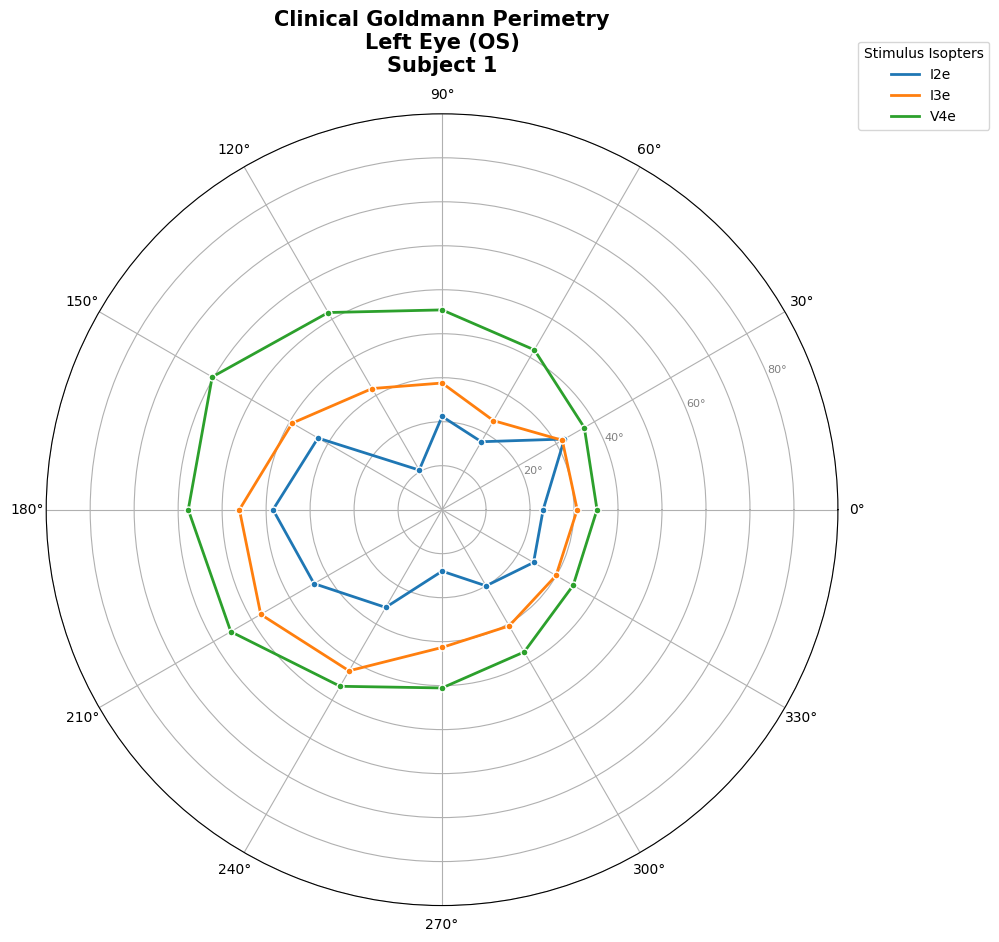

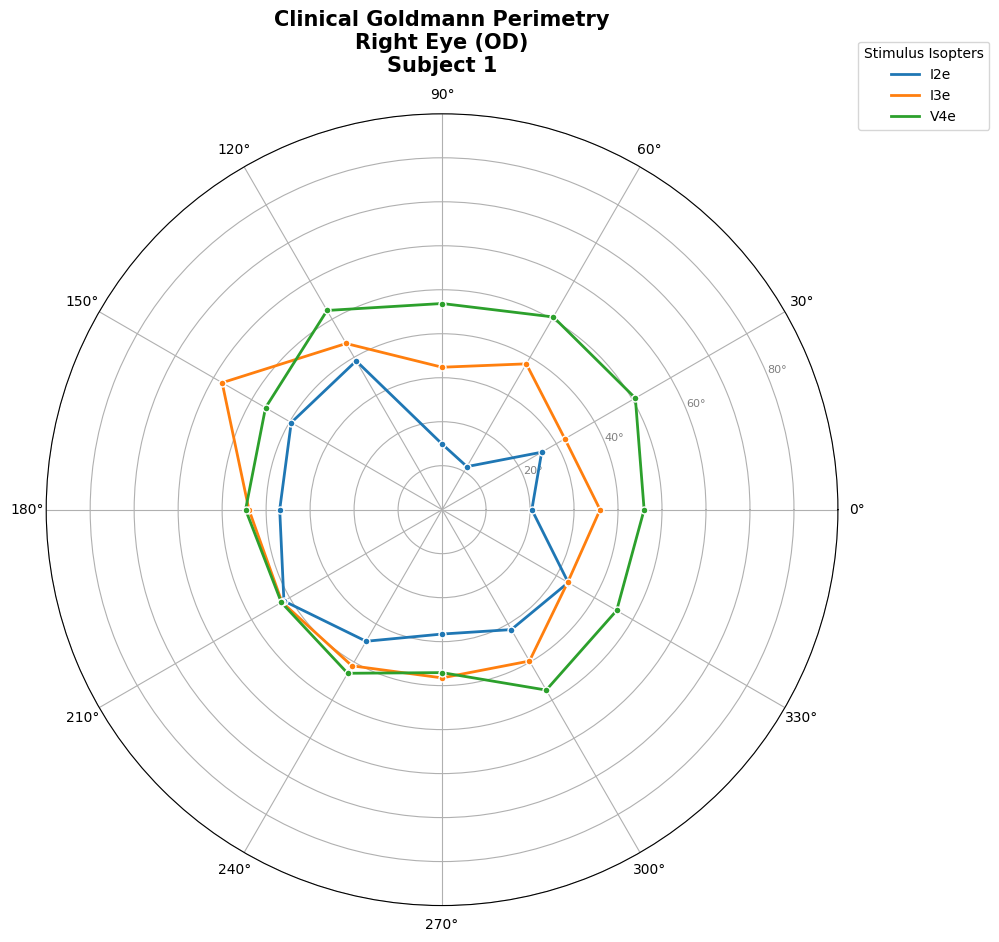

Subject 1 Right RMSE for Stimulus 		I2e: 	11.104563717517268
Subject 1 LEFT RMSE for Stimulus 		I2e: 	8.855731405780228
Subject 1 Right RMSE for Stimulus 		I3e: 	14.505145238670083
Subject 1 LEFT RMSE for Stimulus 		I3e: 	12.8292236527864
Subject 1 Right RMSE for Stimulus 		V4e: 	24.592336317605564
Subject 1 LEFT RMSE for Stimulus 		V4e: 	22.845922307841665


In [7]:
analyse_subject(1)

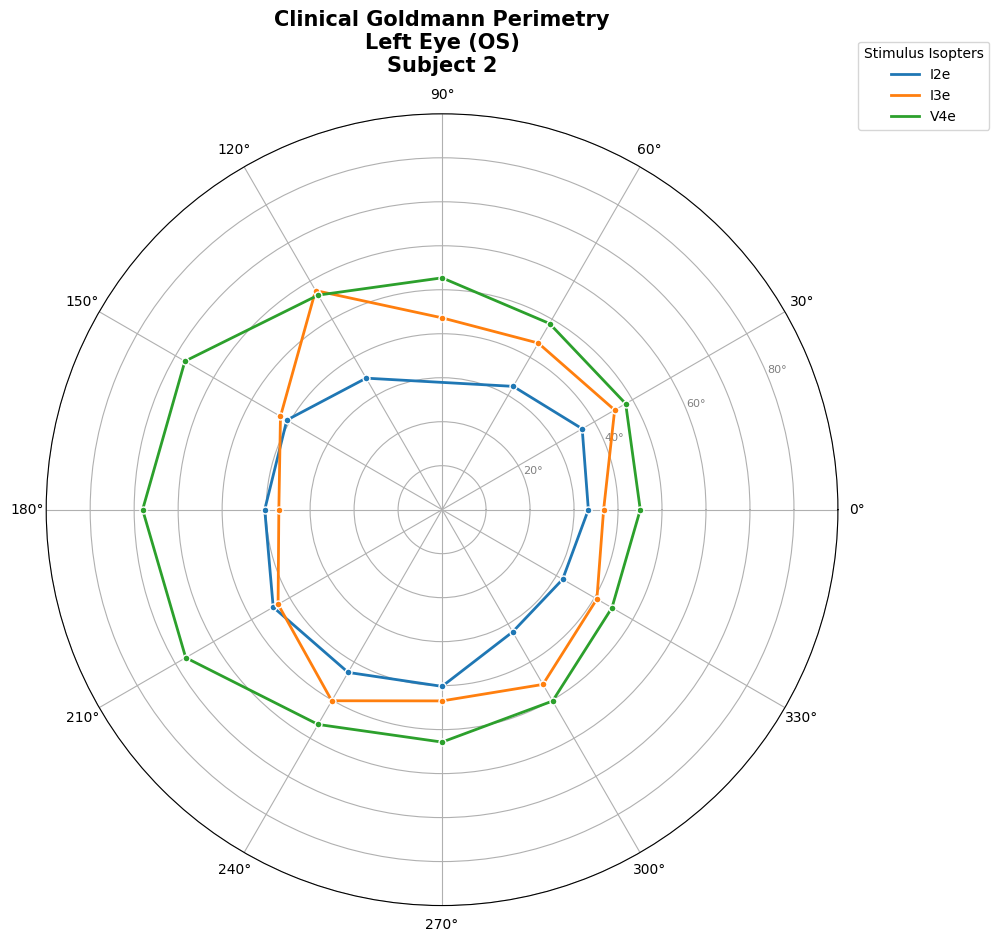

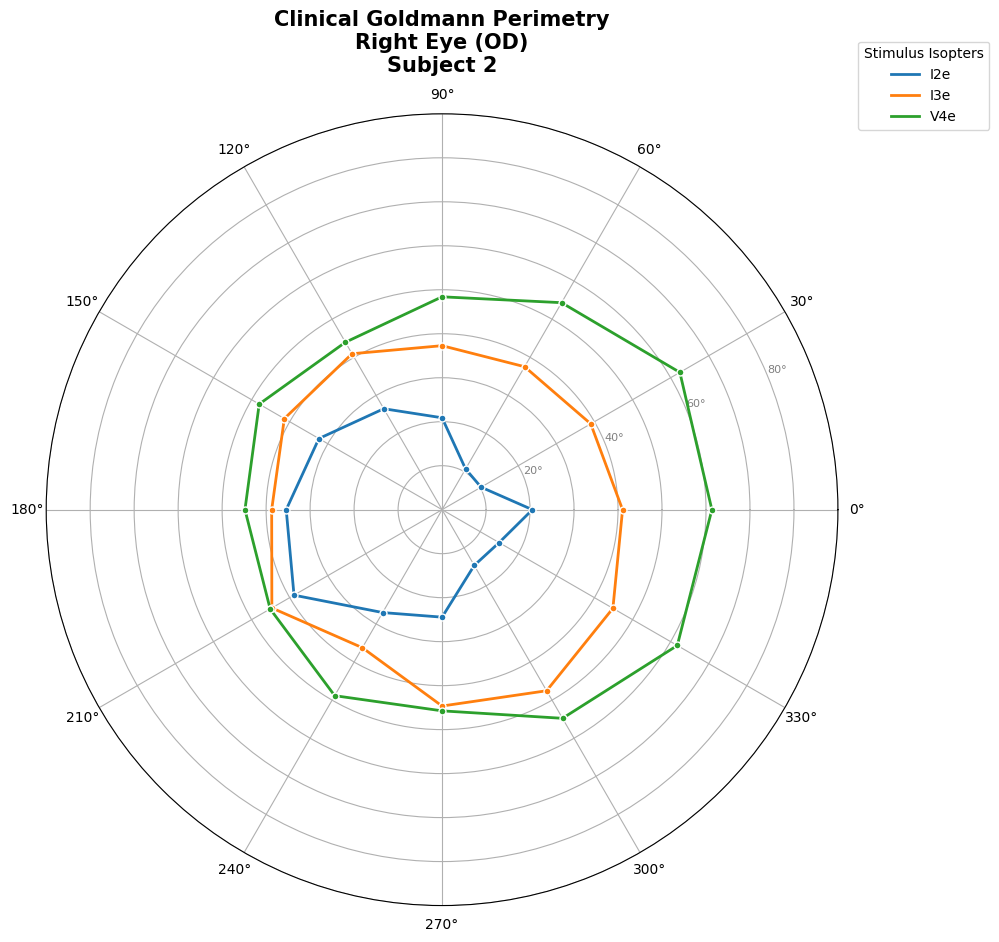

Subject 2 Right RMSE for Stimulus 		I2e: 	14.8521229099121
Subject 2 LEFT RMSE for Stimulus 		I2e: 	5.895776538895913
Subject 2 Right RMSE for Stimulus 		I3e: 	9.426029276843572
Subject 2 LEFT RMSE for Stimulus 		I3e: 	11.526662836500497
Subject 2 Right RMSE for Stimulus 		V4e: 	16.999552036212513
Subject 2 LEFT RMSE for Stimulus 		V4e: 	13.985263797821018


In [8]:
# Subject 2
analyse_subject(2)

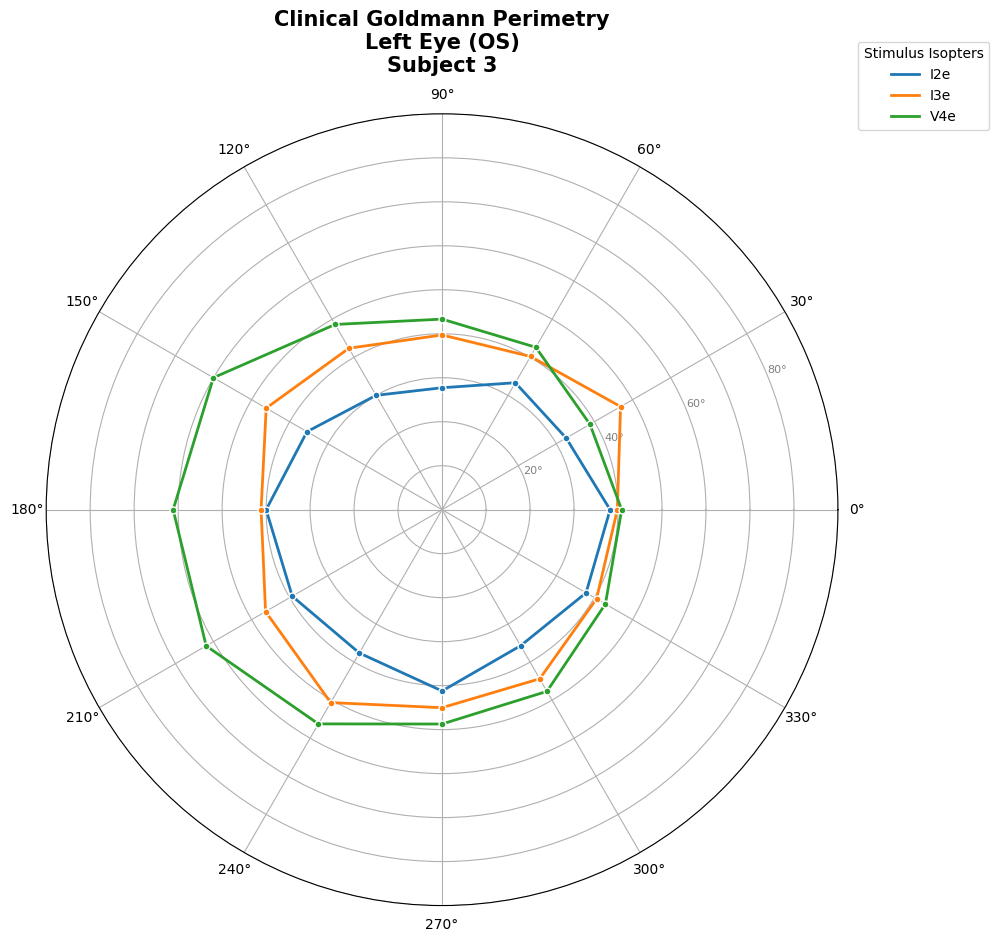

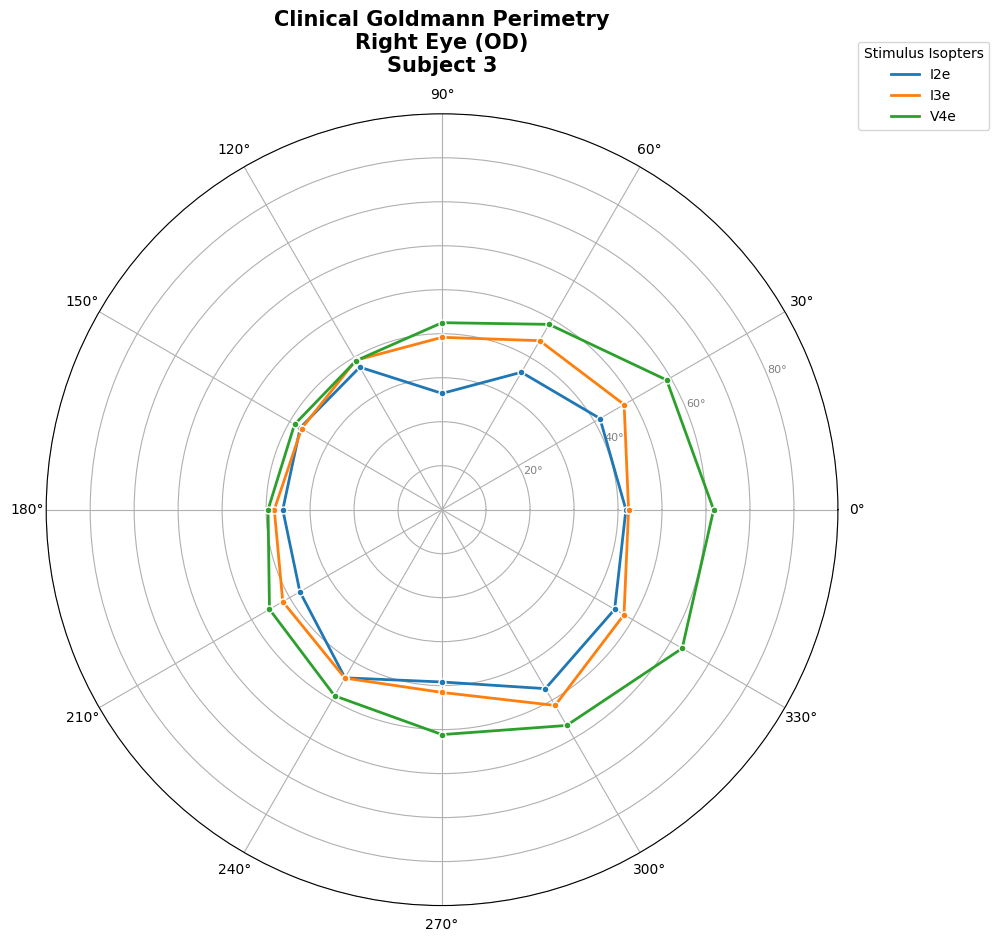

Subject 3 Right RMSE for Stimulus 		I2e: 	8.802187322000268
Subject 3 LEFT RMSE for Stimulus 		I2e: 	6.012831098408514
Subject 3 Right RMSE for Stimulus 		I3e: 	7.96546233324886
Subject 3 LEFT RMSE for Stimulus 		I3e: 	8.280798305170444
Subject 3 Right RMSE for Stimulus 		V4e: 	17.86553452757267
Subject 3 LEFT RMSE for Stimulus 		V4e: 	18.07171954839988


In [9]:
analyse_subject(3)

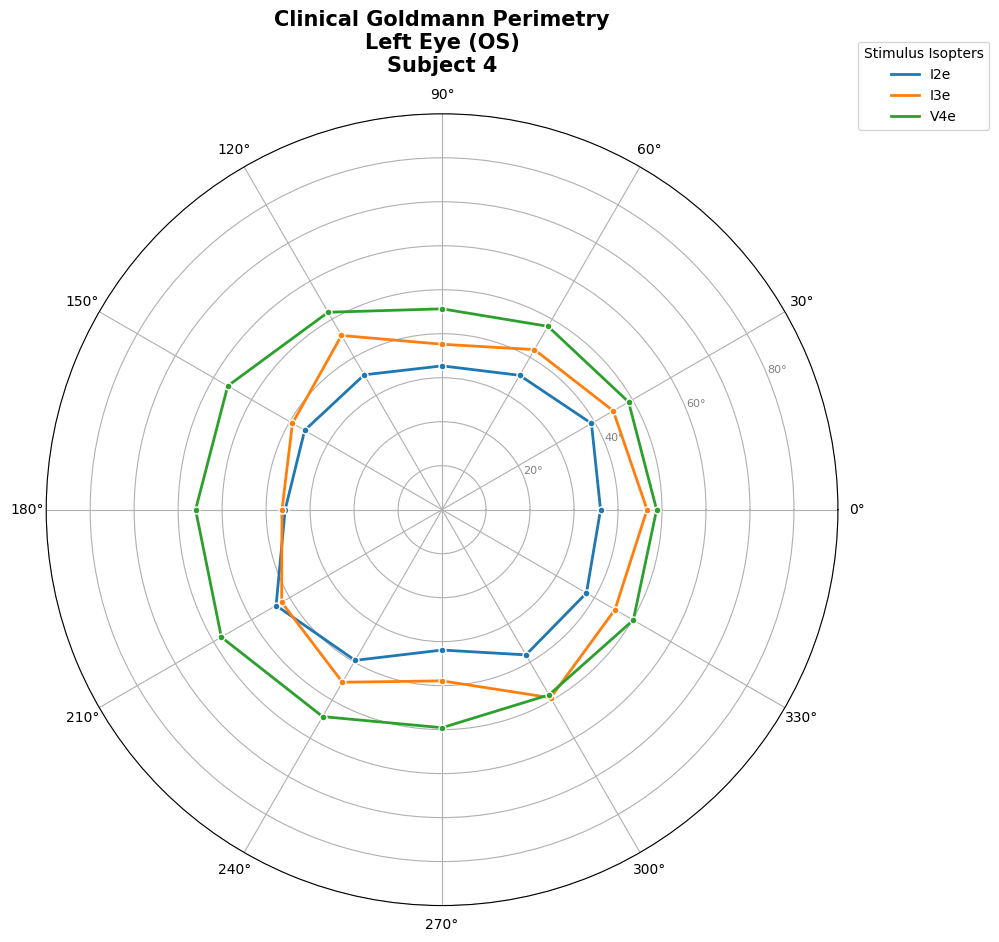

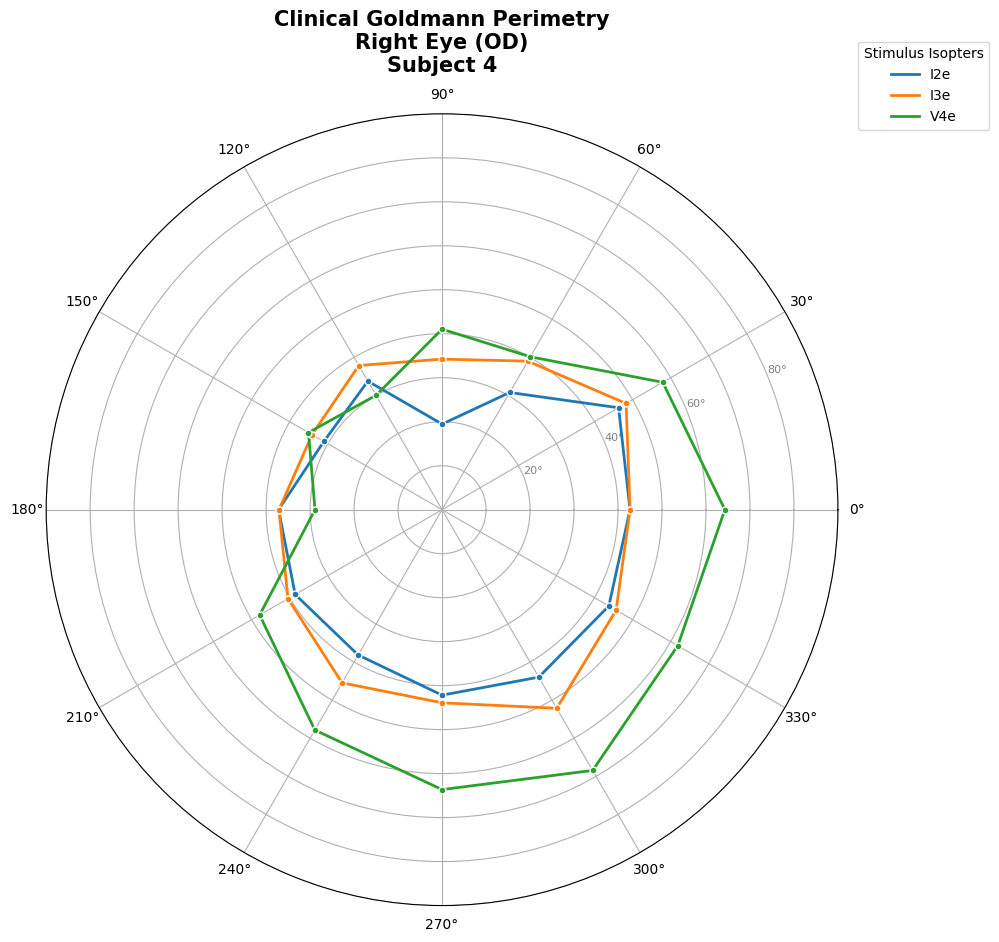

Subject 4 Right RMSE for Stimulus 		I2e: 	7.614220082829544
Subject 4 LEFT RMSE for Stimulus 		I2e: 	7.181617174323387
Subject 4 Right RMSE for Stimulus 		I3e: 	8.279521227915728
Subject 4 LEFT RMSE for Stimulus 		I3e: 	11.16860664712691
Subject 4 Right RMSE for Stimulus 		V4e: 	18.82314151862405
Subject 4 LEFT RMSE for Stimulus 		V4e: 	18.05275640305484


In [10]:
analyse_subject(4)

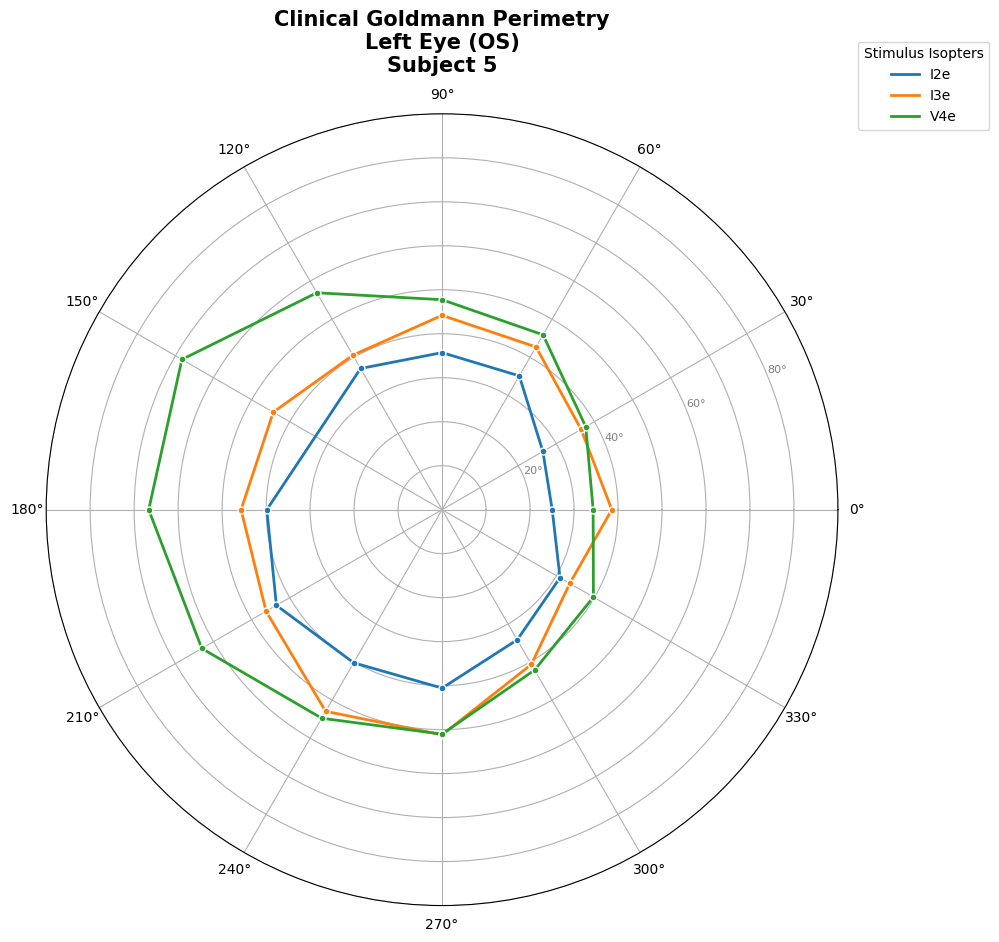

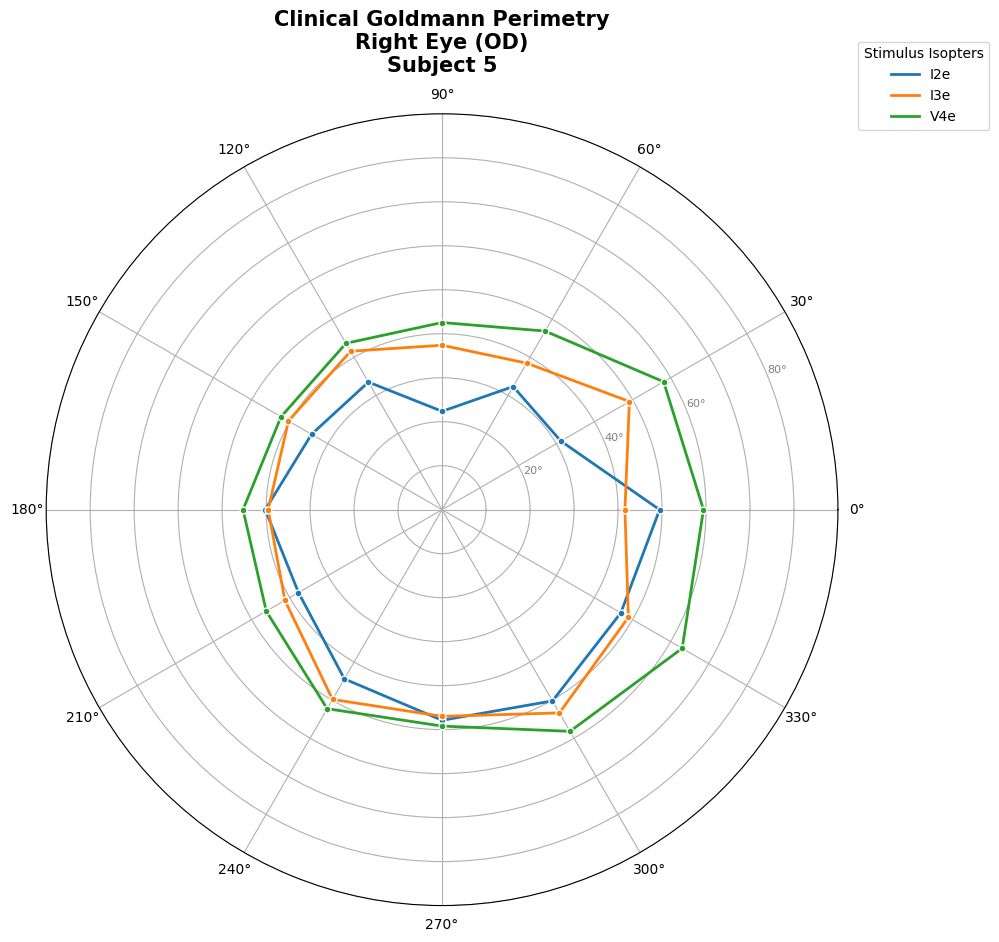

Subject 5 Right RMSE for Stimulus 		I2e: 	10.006582909254705
Subject 5 LEFT RMSE for Stimulus 		I2e: 	7.081718860571213
Subject 5 Right RMSE for Stimulus 		I3e: 	7.724179566191712
Subject 5 LEFT RMSE for Stimulus 		I3e: 	8.543052507986062
Subject 5 Right RMSE for Stimulus 		V4e: 	17.220069165361856
Subject 5 LEFT RMSE for Stimulus 		V4e: 	17.670178710857304


In [11]:
analyse_subject(5)

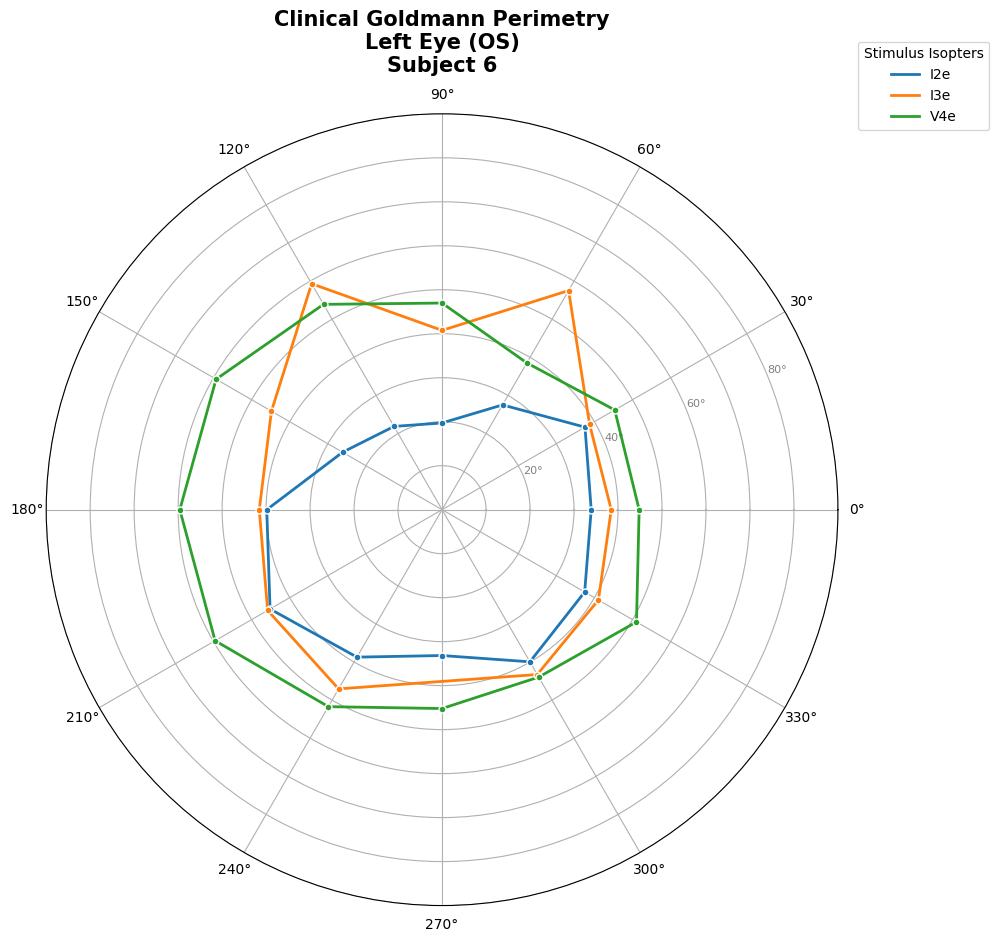

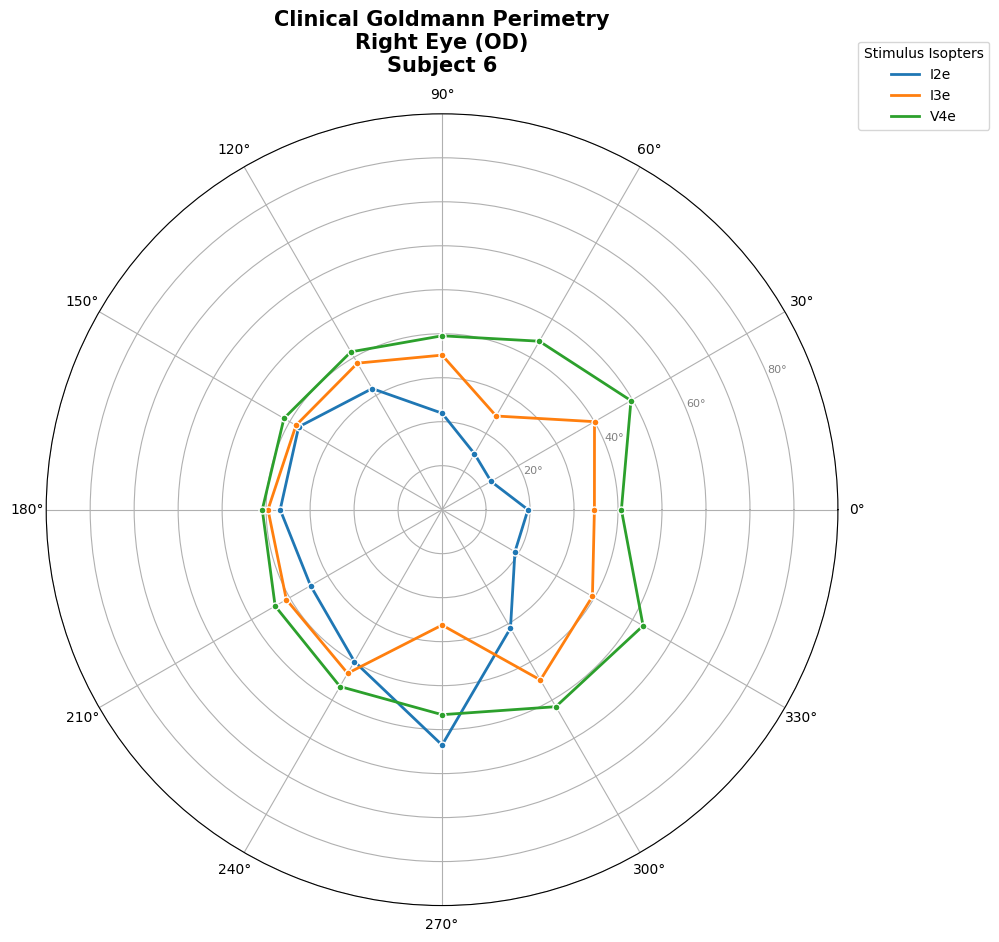

Subject 6 Right RMSE for Stimulus 		I2e: 	14.500844086675118
Subject 6 LEFT RMSE for Stimulus 		I2e: 	6.245635124243008
Subject 6 Right RMSE for Stimulus 		I3e: 	13.66114476433918
Subject 6 LEFT RMSE for Stimulus 		I3e: 	12.238935856101438
Subject 6 Right RMSE for Stimulus 		V4e: 	24.06035179887243
Subject 6 LEFT RMSE for Stimulus 		V4e: 	18.67829381518999


In [12]:
analyse_subject(6)

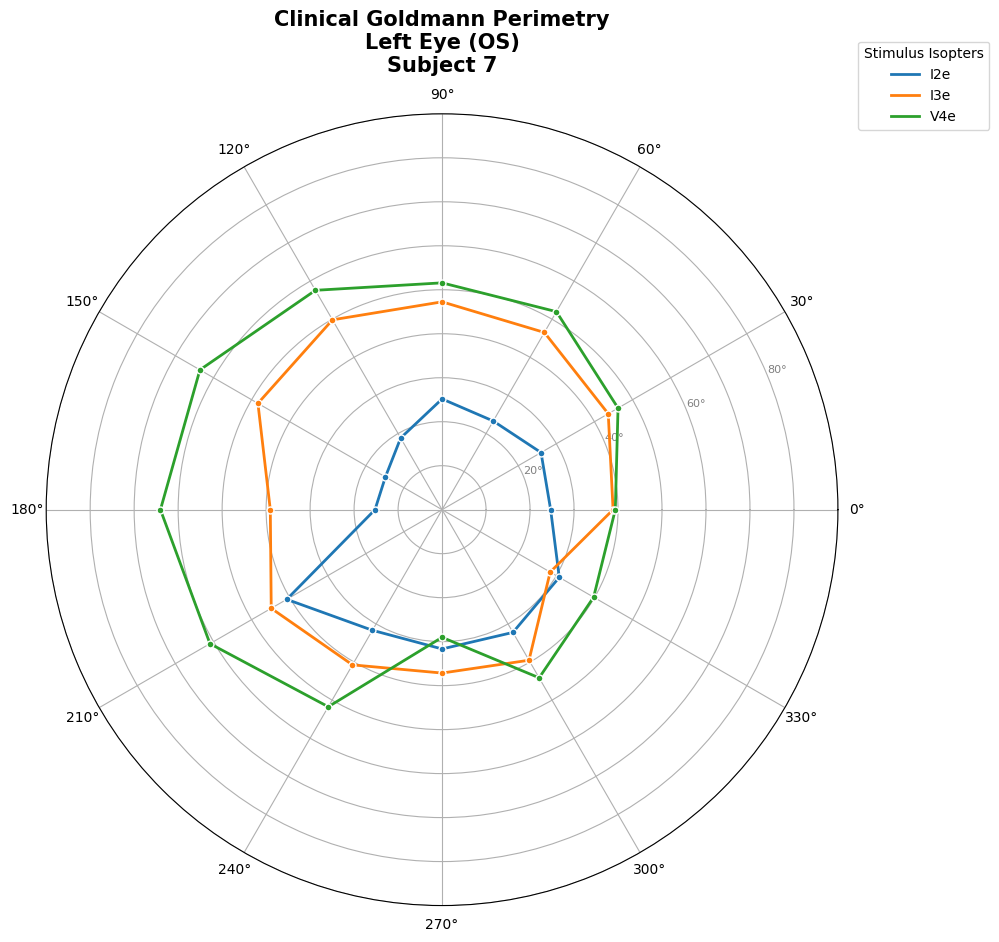

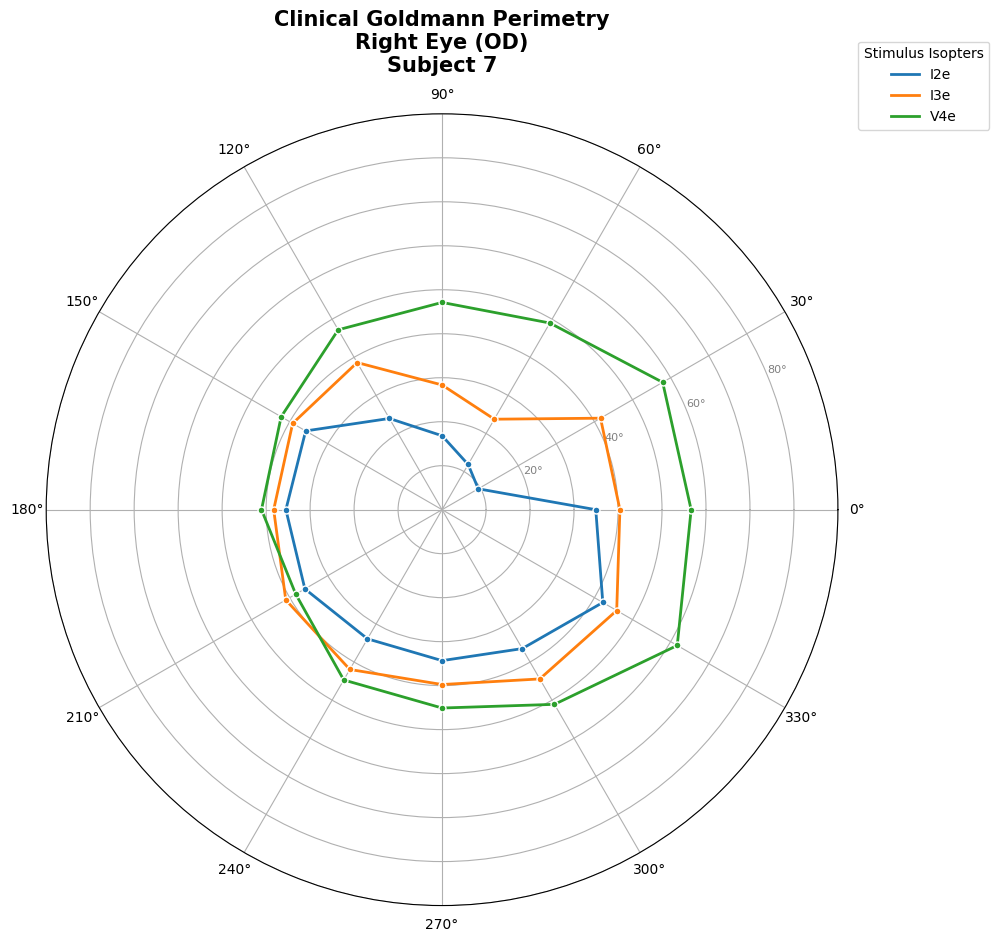

Subject 7 Right RMSE for Stimulus 		I2e: 	9.81465896726905
Subject 7 LEFT RMSE for Stimulus 		I2e: 	10.186082809372481
Subject 7 Right RMSE for Stimulus 		I3e: 	10.762715298278048
Subject 7 LEFT RMSE for Stimulus 		I3e: 	11.958038547672558
Subject 7 Right RMSE for Stimulus 		V4e: 	19.712575776495743
Subject 7 LEFT RMSE for Stimulus 		V4e: 	20.08207865108298


In [13]:
analyse_subject(7)

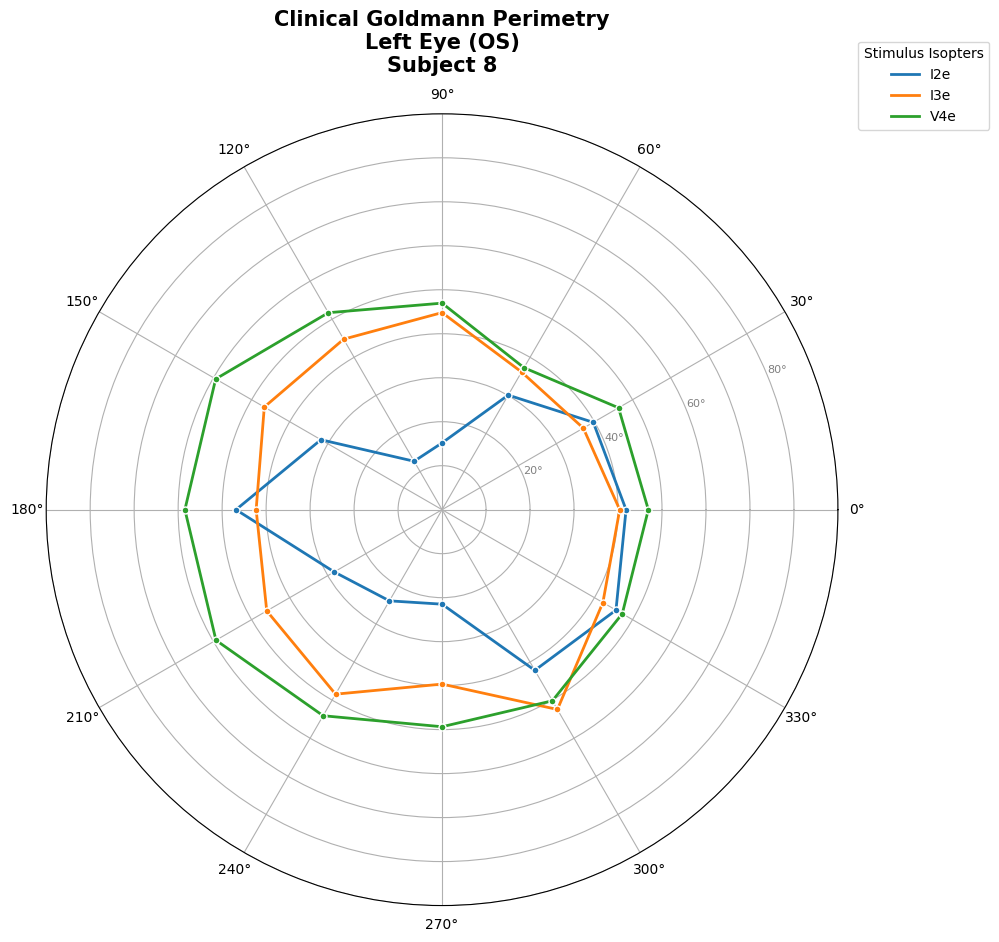

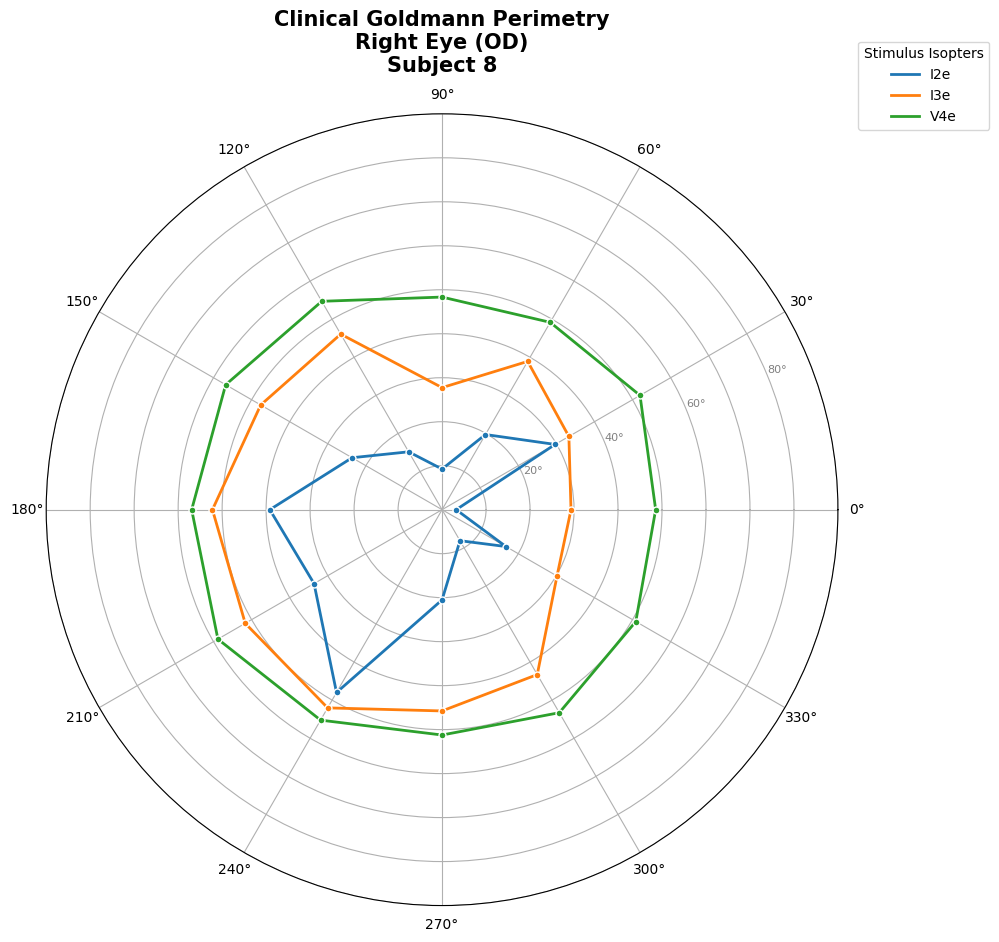

Subject 8 Right RMSE for Stimulus 		I2e: 	17.926578314826592
Subject 8 LEFT RMSE for Stimulus 		I2e: 	11.092924716058668
Subject 8 Right RMSE for Stimulus 		I3e: 	15.743885966681617
Subject 8 LEFT RMSE for Stimulus 		I3e: 	9.324061973998681
Subject 8 Right RMSE for Stimulus 		V4e: 	20.349766884133267
Subject 8 LEFT RMSE for Stimulus 		V4e: 	17.994077029735895


In [14]:
analyse_subject(8)

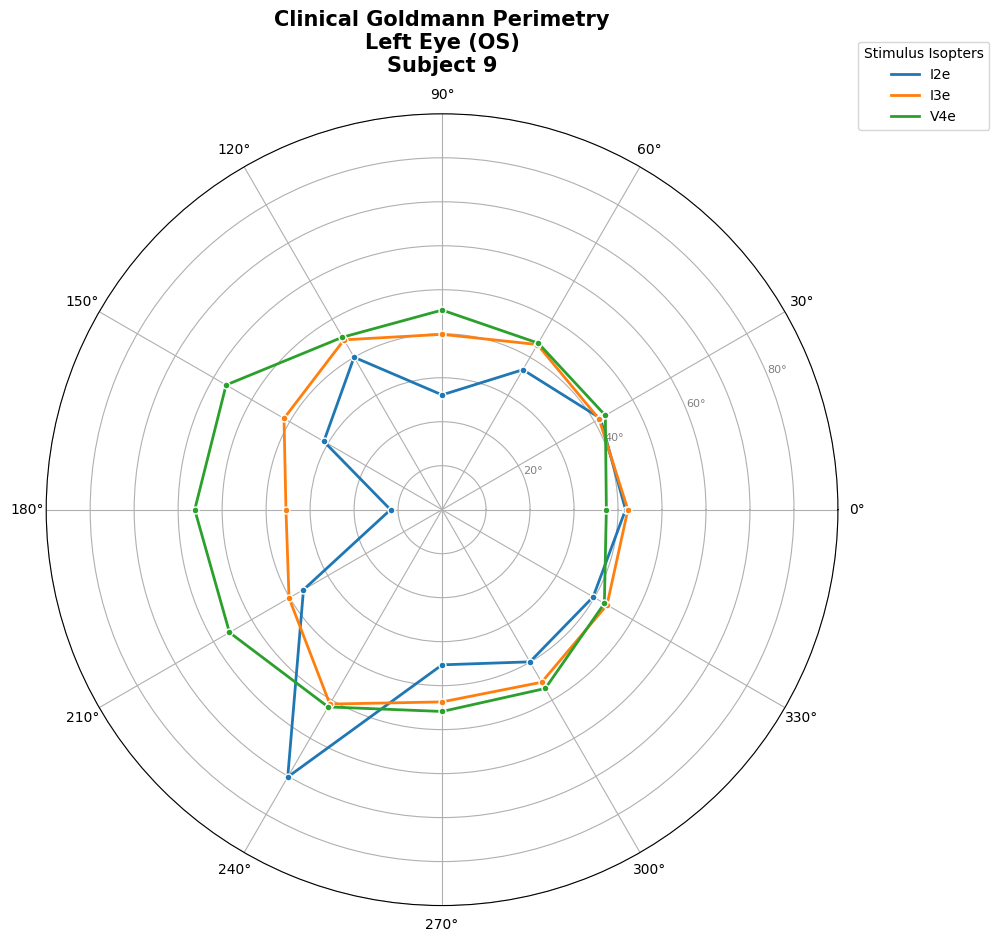

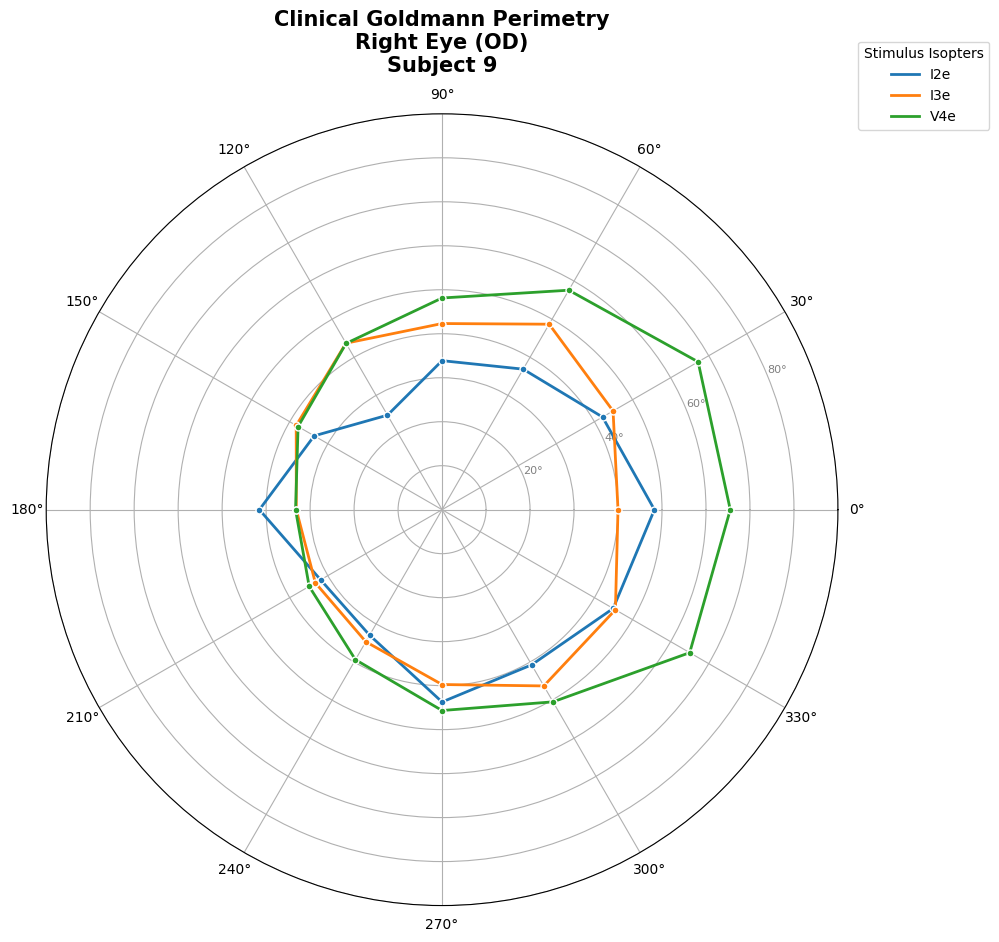

Subject 9 Right RMSE for Stimulus 		I2e: 	7.610355792920834
Subject 9 LEFT RMSE for Stimulus 		I2e: 	15.636390873075646
Subject 9 Right RMSE for Stimulus 		I3e: 	10.789915607610364
Subject 9 LEFT RMSE for Stimulus 		I3e: 	10.825215403640046
Subject 9 Right RMSE for Stimulus 		V4e: 	19.348165341902156
Subject 9 LEFT RMSE for Stimulus 		V4e: 	20.663905713566955


In [15]:
analyse_subject(9)